In [ ]:
!pip install opencv-python numpy scikit-image

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121


import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model



In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/drive/MyDrive/PlantVillage'
train_dir = os.path.join(data_dir)
diseases = os.listdir(train_dir)
print(len(diseases))
#test_dir = os.path.join(data_dir, 'test')

15


Found 8041 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  warnings.warn(


Found 8041 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  warnings.warn(


Found 2014 validated image filenames belonging to 15 classes.


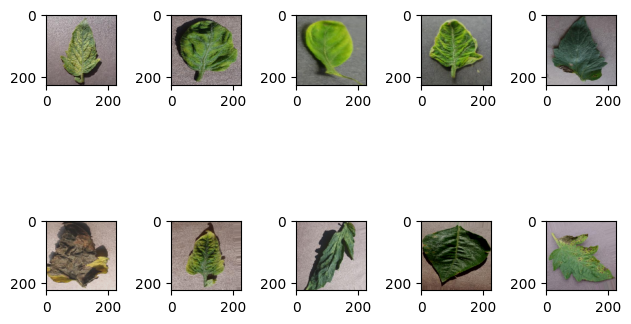

In [ ]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from skimage.util import random_noise
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom preprocessing function for salt-and-pepper noise
def apply_all_preprocessing(image):
    # Apply salt-and-pepper noise
    noisy_image = random_noise(image, mode='s&p', amount=0.02)

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(noisy_image, (5, 5), 0)

    # Apply color enhancement
    hsv = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HSV)

    # Adjust brightness with a random factor within a specified range
    brightness_factor = np.random.uniform(0.5, 0.6)
    hsv[..., 2] = np.clip(hsv[..., 2] * brightness_factor, 0, 255)

    # Adjust saturation
    saturation_factor = np.random.uniform(0.8, 1.2)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation_factor, 0, 255)

    enhanced_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Introduce minute changes
    final_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)
    final_image = random_noise(final_image, mode='s&p', amount=0.005)

    # Convert to uint8
    final_image = (255 * final_image).astype(image.dtype)

    return final_image

# Set your dataset path
dataset_path = '/content/drive/MyDrive/PlantVillage'

# Get a list of all subdirectories (categories) in the dataset
categories = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category))]

# Create empty lists to store training and testing paths for each category
train_paths = []
test_paths = []

# Iterate through each category
for category in categories:
    # Get the list of image file paths in the current category
    category_paths = [os.path.join(dataset_path, category, filename) for filename in os.listdir(os.path.join(dataset_path, category))]

    # Split the current category into 80% train and 20% test
    category_train_paths, category_test_paths = train_test_split(category_paths, test_size=0.2, random_state=42)

    # Append the category-wise paths to the overall lists
    train_paths.extend(category_train_paths)
    test_paths.extend(category_test_paths)

# Create DataFrame for train and test paths
train_df = pd.DataFrame({'File': train_paths, 'Label': [os.path.dirname(file) for file in train_paths]})
test_df = pd.DataFrame({'File': test_paths, 'Label': [os.path.dirname(file) for file in test_paths]})

original_datagen = ImageDataGenerator(rescale=1./255.0)

# Create ImageDataGenerator with augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255.0,  # Update rescale to a float value
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=50.0
    #preprocessing_function=apply_all_preprocessing  # Apply all preprocessing steps
)


# Create ImageDataGenerator without augmentation for testing data
test_datagen = ImageDataGenerator(rescale=1./255.0)  # Update rescale to a float value

# Load and preprocess training data
train_data = train_datagen.flow_from_dataframe(train_df, x_col='File', y_col='Label', target_size=(224, 224), batch_size=32, class_mode='categorical')
original_data = original_datagen.flow_from_dataframe(train_df, x_col='File', y_col='Label', target_size=(224, 224), batch_size=32, class_mode='categorical')
# Load and preprocess testing data
test_data = test_datagen.flow_from_dataframe(test_df, x_col='File', y_col='Label', target_size=(224, 224), batch_size=32, class_mode='categorical')



# Example: Visualize some augmented images from the training set
import matplotlib.pyplot as plt

# Generate augmented images for training data
augmented_images = train_data.next()

# Display the original and augmented images
for i in range(5):
    augmented_image = augmented_images[0][i]
    plt.subplot(2, 5, i + 1)
    original_image, _ = original_data.next()  # Original image
    plt.imshow(original_image[0])

    plt.subplot(2, 5, i + 6)
                                # Augmented image (with all preprocessing steps)
    plt.imshow(augmented_image)
plt.tight_layout()
plt.show()


In [ ]:
train_data


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Residual Convolution Module (RCM)
def residual_conv_module(x, filters, kernel_size=3):
    res = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.Activation('relu')(res)

    res = layers.Conv2D(filters, kernel_size=(kernel_size, kernel_size), padding='same')(res)
    res = layers.BatchNormalization()(res)
    res = layers.Activation('relu')(res)

    res = layers.Conv2D(filters*4, kernel_size=(1, 1), padding='same')(res)
    res = layers.BatchNormalization()(res)

    # Adjust the shortcut connection dimensions
    shortcut = layers.Conv2D(filters*4, kernel_size=(1, 1), padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)

    # Apply element-wise addition with input x
    x = layers.Add()([shortcut, res])
    x = layers.Activation('relu')(x)
    return x

# Define the Identity Mapping Module (IMM)
def identity_mapping_module(x, filters, strides=(1, 1)):
    shortcut = x  # Save the input for the shortcut connection

    res = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.Activation('relu')(res)

    res = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(res)
    res = layers.BatchNormalization()(res)
    res = layers.Activation('relu')(res)

    res = layers.Conv2D(filters*4, kernel_size=(1, 1), padding='same')(res)
    res = layers.BatchNormalization()(res)

    # Adjust the shortcut connection dimensions
    shortcut = layers.Conv2D(filters*4, kernel_size=(1, 1), strides=strides, padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)

    # Apply element-wise addition with the shortcut
    x = layers.Add()([shortcut, res])
    x = layers.Activation('relu')(x)
    return x

# Define the ResNet50 model
def resnet50(input_shape=(224, 224, 3), num_classes=15):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual Convolution Stages
    for stage, filters, blocks in zip([2, 3, 4, 5], [64, 128, 256, 512], [3, 4, 6, 3]):
        for block in range(blocks):
            if block == 0:
                # The first block in each stage may need a shortcut connection
                x = identity_mapping_module(x, filters, strides=(2, 2))
            else:
                x = residual_conv_module(x, filters)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Create the ResNet50 model
model = resnet50()

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['batch_normalization_1[0]

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# ... (Define identity_mapping_module, residual_conv_module, and resnet50 as in your first code)

# Load and preprocess training data
train_data = train_datagen.flow_from_dataframe(train_df, x_col='File', y_col='Label', target_size=(224, 224), batch_size=32, class_mode='categorical')

# Load the ResNet50 model with pre-trained weights on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extraction model using specific layers
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

# Residual Convolution Stages
for stage, filters, blocks in zip([2, 3, 4, 5], [64, 128, 256, 512], [3, 4, 6, 3]):
    for block in range(blocks):
        if block == 0:
            x = identity_mapping_module(x, filters, strides=(2, 2))
        else:
            x = residual_conv_module(x, filters)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Additional layers for feature extraction
x = Dense(512, activation='relu')(x)
num_features=256
output_tensor = Dense(num_features, activation='linear')(x)

# Create the feature extraction model
feature_extraction_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the feature extraction model
feature_extraction_model.compile(optimizer=Adam(learning_rate=0.001),
                                 loss=CategoricalCrossentropy(),
                                 metrics=[Accuracy()])

# Extract features from the training data
train_features = feature_extraction_model.predict(train_data)

# Display the shape of the extracted features
print("Shape of Extracted Features from Training Data:", train_features.shape)


Found 8041 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  warnings.warn(


252/252 [==============================] - 1891s 7s/step
Shape of Extracted Features from Training Data: (8041, 256)


In [ ]:
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np

def initialize_population(NPOP, num_features):
    return np.random.rand(NPOP, num_features)

def develop_objective_function(population, features_from_resnet50):
    # Placeholder for the actual objective function
    # Replace this with your specific objective function
    return np.sum(population * features_from_resnet50, axis=1)

def local_search(male_old, a1, a2, UB, LB):
    a3 = np.random.rand()
    male_new = male_old + a1 * ((UB - LB) * a2) + LB if a3 >= 0.5 else male_old - a1 * ((UB - LB) * a2) + LB
    return male_new

def mating(commander, hinds, c, UB, LB):
    n = len(hinds)
    index1 = int(np.random.rand() * n)
    index2 = int(np.random.rand() * n)
    com_feature = commander[int(np.random.rand() * len(commander))]
    new1 = com_feature + hinds[index1] * c * (UB - LB) + LB
    new2 = com_feature + hinds[index2] * c * (UB - LB) + LB
    return np.vstack((new1, new2))

def mrdoa_algorithm(features_from_resnet50, NPOP, NMRD, a, b, c, Maxit):
    num_features = features_from_resnet50.shape[1]
    population = initialize_population(NPOP, num_features)

    for _ in range(Maxit):
        objective_values = develop_objective_function(population, features_from_resnet50)
        sorted_indices = np.argsort(objective_values)
        sorted_population = population[sorted_indices]

        stags_count = int(NMRD - NMRD * a)
        commanders_count = NMRD - stags_count
        stags = sorted_population[:stags_count]
        commanders = sorted_population[stags_count: stags_count + commanders_count]

        for i in range(commanders_count):
            commanders[i] = local_search(commanders[i], a, np.random.rand(), UB, LB)

        harems = [commanders[i:i + stags_count] for i in range(0, NMRD, stags_count)]

        for i in range(stags_count):
            harem = harems[i]
            commander = harem[0]
            hinds = harem[1:]
            population[i * commanders_count:i * commanders_count + commanders_count] = mating(commander, hinds, np.random.rand(), UB, LB)

    return population

# Example usage
features_from_resnet50 = np.random.rand(100, 256)
NPOP = 100
NMRD = 50
a = 0.2
b = 0.3
c = 0.5
Maxit = 100

optimal_features = mrdoa_algorithm(features_from_resnet50, NPOP, NMRD, a, b, c, Maxit)
print("Optimal Features:", optimal_features)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	10    
1  	17    
2  	19    
3  	20    
4  	19    
5  	17    
6  	17    
7  	18    
8  	20    
9  	19    
10 	17    
11 	19    
12 	20    
13 	17    
14 	19    
15 	19    
16 	15    
17 	18    
18 	17    
19 	16    
20 	18    
21 	20    
22 	20    
23 	15    
24 	19    
25 	18    
26 	18    
27 	18    
28 	18    
29 	17    
30 	17    
31 	18    
32 	20    
33 	19    
34 	19    
35 	15    
36 	19    
37 	18    
38 	18    
39 	17    
40 	17    
41 	17    
42 	18    
43 	20    
44 	18    
45 	18    
46 	18    
47 	17    
48 	17    
49 	18    
50 	19    
Selected Features: [1, 2, 3, 4, 5, 6, 9, 20, 21, 22, 25, 26, 27, 29, 30, 33, 35, 39, 41, 42, 43, 44, 45, 47, 48, 50, 51, 55, 56, 57, 59, 60, 61, 62, 63, 65, 70, 71, 73, 74, 75, 77, 79, 80, 81, 82, 84, 85, 92, 94, 97, 104, 106, 108, 111, 113, 118, 119, 121, 122, 126, 127, 128, 129, 130, 132, 133, 134, 142, 146, 147, 155, 156, 157, 158, 160, 161, 162, 169, 172, 174, 175, 177, 178, 183, 184, 185, 186, 190, 191, 195, 196, 197, 1

In [ ]:
# Use the selected features to subset the training features
selected_train_features = train_features[:, selected_features]

# Assuming you have labels for your training data (replace 'train_labels' with your actual labels)
train_labels = train_data.labels

# Convert labels to one-hot encoding
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=15)

# Create a new model for classification using selected features
classification_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(selected_features),)),
    Dense(15, activation='softmax')
])

# Compile the classification model
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classification model using selected features
classification_model.fit(selected_train_features, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2)

# Now, you can use this classification model for making predictions on new data.
# You may need to extract selected features from new data using the feature_extraction_model
# and then use the classification_model for predictions.

# For example, assuming you have new data in 'X_test' (replace with your actual test data)
selected_test_features = feature_extraction_model.predict(test_data)[:, selected_features]

# Make predictions using the classification model
predictions = classification_model.predict(selected_test_features)

# Perform any post-processing or evaluation as needed


Epoch 1/10
201/201 [==============================] - 2s 5ms/step - loss: 2.1073 - accuracy: 0.3975 - val_loss: 4.4930 - val_accuracy: 0.0000e+00
Epoch 2/10
201/201 [==============================] - 1s 4ms/step - loss: 1.7991 - accuracy: 0.3989 - val_loss: 5.4799 - val_accuracy: 0.0000e+00
Epoch 3/10
201/201 [==============================] - 1s 4ms/step - loss: 1.7861 - accuracy: 0.3989 - val_loss: 6.0195 - val_accuracy: 0.0000e+00
Epoch 4/10
201/201 [==============================] - 1s 4ms/step - loss: 1.7823 - accuracy: 0.3989 - val_loss: 6.4761 - val_accuracy: 0.0000e+00
Epoch 5/10
201/201 [==============================] - 1s 4ms/step - loss: 1.7817 - accuracy: 0.3989 - val_loss: 6.8262 - val_accuracy: 0.0000e+00
Epoch 6/10
201/201 [==============================] - 1s 4ms/step - loss: 1.7805 - accuracy: 0.3989 - val_loss: 7.0504 - val_accuracy: 0.0000e+00
Epoch 7/10
201/201 [==============================] - 1s 6ms/step - loss: 1.7804 - accuracy: 0.3989 - val_loss: 7.2347 - val

In [ ]:
train_df

,File,Label
0,/content/drive/MyDrive/PlantVillage/Tomato__To...,/content/drive/MyDrive/PlantVillage/Tomato__To...
1,/content/drive/MyDrive/PlantVillage/Tomato__To...,/content/drive/MyDrive/PlantVillage/Tomato__To...
2,/content/drive/MyDrive/PlantVillage/Tomato__To...,/content/drive/MyDrive/PlantVillage/Tomato__To...
3,/content/drive/MyDrive/PlantVillage/Tomato__To...,/content/drive/MyDrive/PlantVillage/Tomato__To...
4,/content/drive/MyDrive/PlantVillage/Tomato__To...,/content/drive/MyDrive/PlantVillage/Tomato__To...
...,...,...
8037,/content/drive/MyDrive/PlantVillage/Pepper__be...,/content/drive/MyDrive/PlantVillage/Pepper__be...
8038,/content/drive/MyDrive/PlantVillage/Pepper__be...,/content/drive/MyDrive/PlantVillage/Pepper__be...
8039,/content/drive/MyDrive/PlantVillage/Pepper__be...,/content/drive/MyDrive/PlantVillage/Pepper__be...
8040,/content/drive/MyDrive/PlantVillage/Pepper__be...,/content/drive/MyDrive/PlantVillage/Pepper__be...


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    parts = plant.split('___')
    if len(parts) >= 2:  # Make sure there are at least two parts after splitting
        if parts[0] not in plants:
            plants.append(parts[0])
        if len(parts) >= 2 and parts[1] != 'healthy':
            NumberOfDiseases += 1
    else:
        print(f"Ignoring invalid entry: {plant}")

print("Plants:", plants)
print("Number of Diseases:", NumberOfDiseases)

Ignoring invalid entry: Tomato__Tomato_YellowLeaf__Curl_Virus
Ignoring invalid entry: Tomato_Early_blight
Ignoring invalid entry: Tomato_healthy
Ignoring invalid entry: Tomato__Tomato_mosaic_virus
Ignoring invalid entry: Tomato_Late_blight
Ignoring invalid entry: Tomato_Leaf_Mold
Ignoring invalid entry: Tomato_Spider_mites_Two_spotted_spider_mite
Ignoring invalid entry: Tomato_Septoria_leaf_spot
Ignoring invalid entry: Tomato__Target_Spot
Ignoring invalid entry: Tomato_Bacterial_spot
Plants: ['Potato', 'Pepper__bell']
Number of Diseases: 3


In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato__Tomato_YellowLeaf__Curl_Virus,3209
Tomato_Early_blight,290
Tomato_healthy,290
Tomato__Tomato_mosaic_virus,373
Tomato_Late_blight,294
Tomato_Leaf_Mold,300
Tomato_Spider_mites_Two_spotted_spider_mite,1676
Tomato_Septoria_leaf_spot,658
Tomato__Target_Spot,1404
Tomato_Bacterial_spot,290


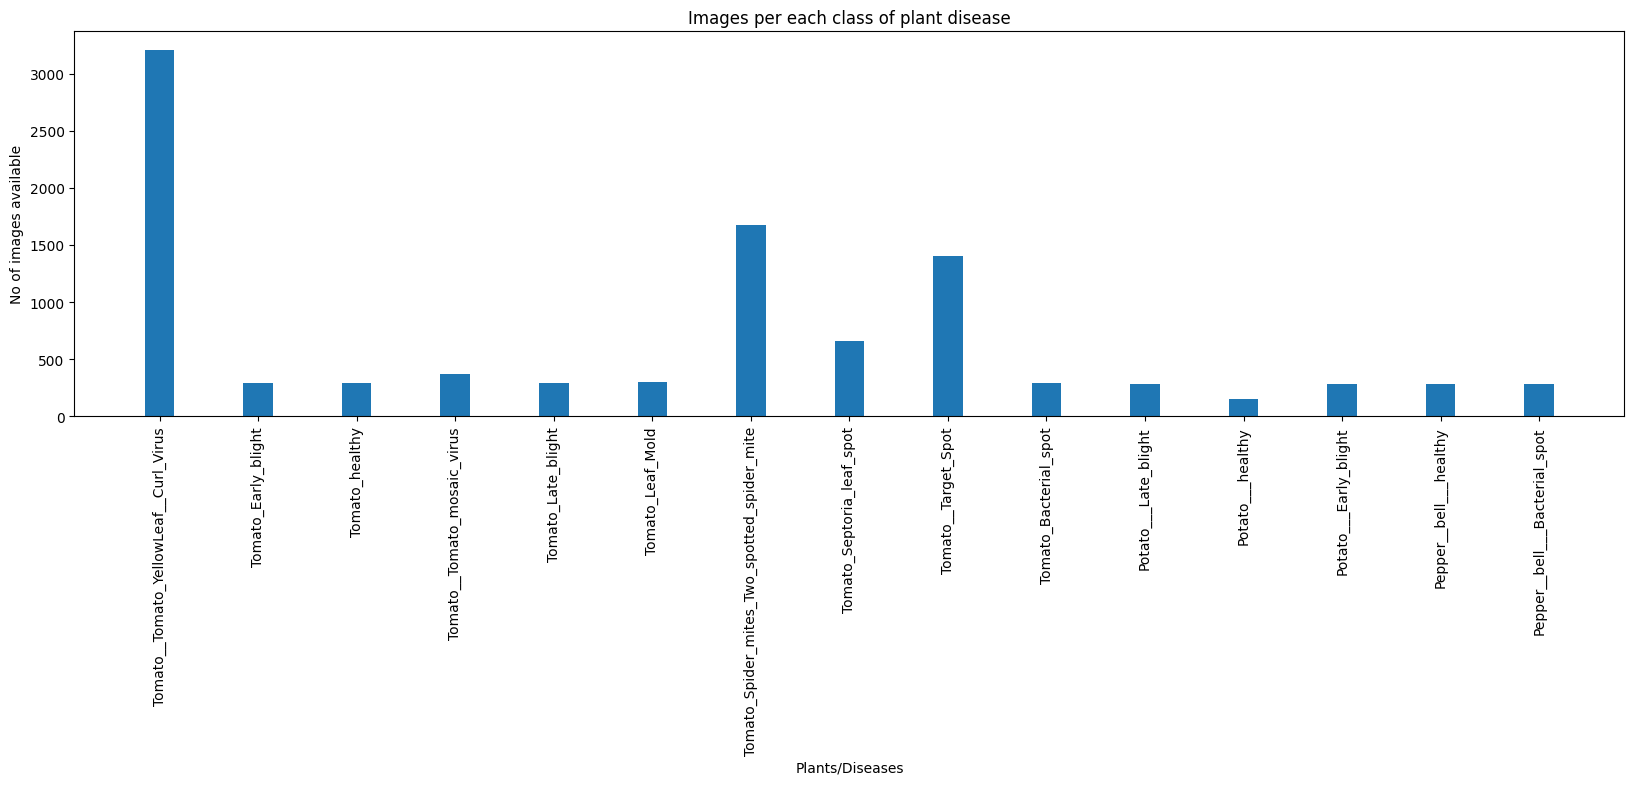

In [ ]:
# Assuming 'nums' is a dictionary with plant/disease names as keys and corresponding image counts as values

index = [n for n in range(len(nums))]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, [plant for plant in nums.keys()], rotation=90)  # Rotate x-axis labels for better readability
plt.title('Images per each class of plant disease')
plt.show()


In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 10056 images for training


In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
print(len(set(train['DiseaseID'])))
train.tail()

15


,File,DiseaseID,Disease Type
10051,Tomato_healthy/2d02a0d6-0734-4ac7-957f-44f2a01...,14,Tomato_healthy
10052,Tomato_healthy/2b50c7a7-e22e-4103-9e23-909377a...,14,Tomato_healthy
10053,Tomato_healthy/2b21cbfc-9c23-42fb-984c-9439fa8...,14,Tomato_healthy
10054,Tomato_healthy/2d6ecece-b67e-42f1-924b-3a5dbd9...,14,Tomato_healthy
10055,Tomato_healthy/2d9352d7-2509-40a1-be35-0140444...,14,Tomato_healthy


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato__Tomato_YellowLeaf__Curl_Virus/1cd27c22...,12,Tomato__Tomato_YellowLeaf__Curl_Virus
1,Tomato__Target_Spot/e0305b9d-488b-4fe0-8472-8b...,11,Tomato__Target_Spot
2,Potato___healthy/170f1f57-0fd4-421f-9c82-3b180...,4,Potato___healthy
3,Tomato__Tomato_YellowLeaf__Curl_Virus/2e590d43...,12,Tomato__Tomato_YellowLeaf__Curl_Virus
4,Pepper__bell___Bacterial_spot/1ade72cf-f7e0-42...,0,Pepper__bell___Bacterial_spot


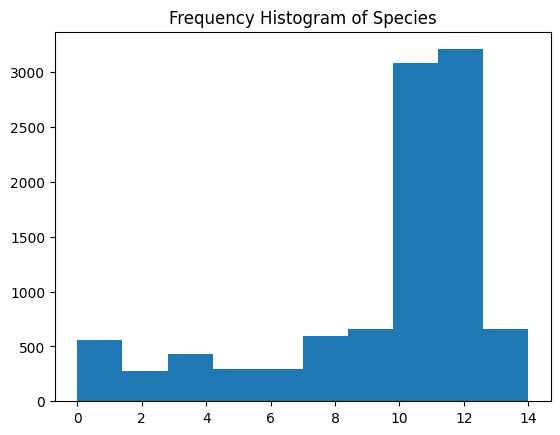

<Figure size 1200x1200 with 0 Axes>

In [ ]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

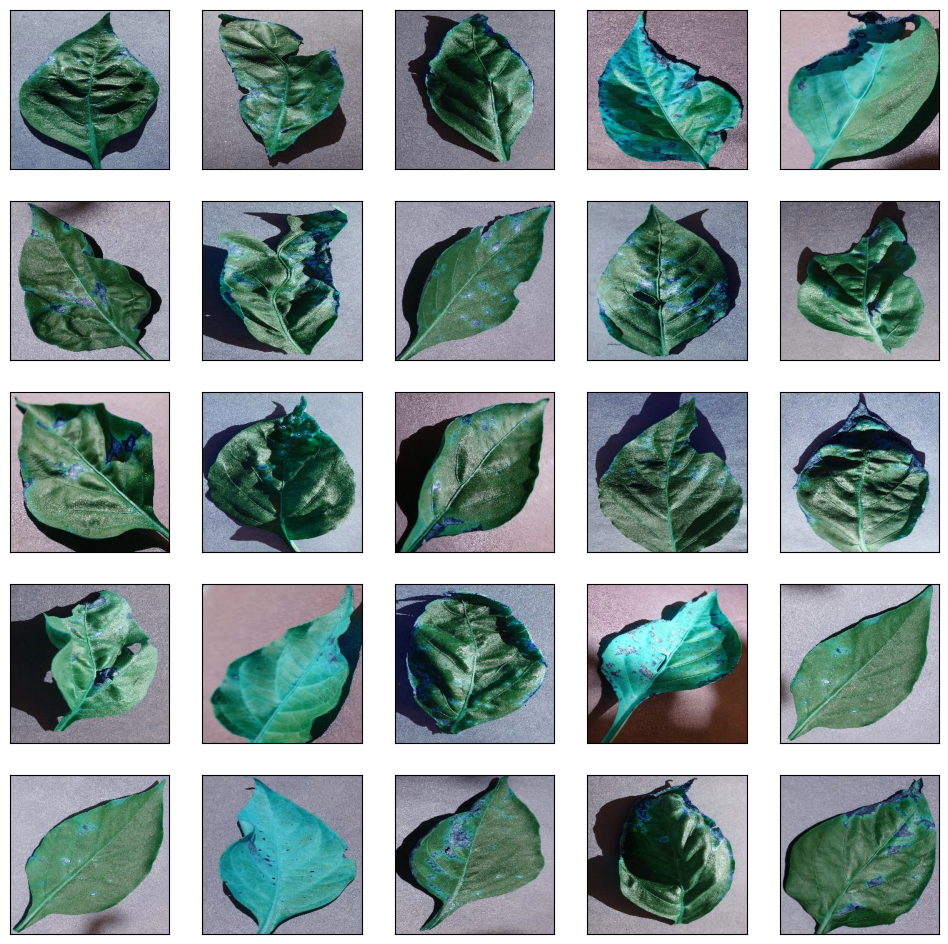

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Pepper__bell___Bacterial_spot', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
# Helper functions for preprocessing
def apply_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = image.copy()
    total_pixels = image.size

    salt_pixels = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, salt_pixels) for i in image.shape]
    noisy_image[salt_coords] = 1

    pepper_pixels = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, pepper_pixels) for i in image.shape]
    noisy_image[pepper_coords] = 0

    return noisy_image

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def random_scaling_and_rotation(image):
    scale_factor = np.random.uniform(0.95, 1.05)
    scaled_image = cv2.resize(image.copy(), None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    rotation_angle = np.random.uniform(-30, 30)
    rows, cols, _ = scaled_image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
    rotated_image = cv2.warpAffine(scaled_image, rotation_matrix, (cols, rows))

    return rotated_image

def position_augmentation(image):
    angles = [45, 135, 225, 315]
    flipped_image = np.fliplr(image)
    augmented_images = [cv2.warpAffine(image, cv2.getRotationMatrix2D((IMAGE_SIZE / 2, IMAGE_SIZE / 2), angle, 1), (IMAGE_SIZE, IMAGE_SIZE)) for angle in angles]
    augmented_images.extend([image, flipped_image])

    return augmented_images

def color_augmentation(image):
    enhanced_image = image.copy()

    # Convert the image to grayscale
    enhanced_image_gray = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2GRAY)

    # Apply histogram equalization for contrast enhancement
    enhanced_image_gray = cv2.equalizeHist(enhanced_image_gray)

    # Convert the grayscale image back to RGB
    enhanced_image = cv2.cvtColor(enhanced_image_gray, cv2.COLOR_GRAY2RGB)

    return enhanced_image


# Load your training data
train_data = train  # Your training data

# Apply preprocessing to each image
preprocessed_images = []

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        # Apply preprocessing steps
        noisy_image = image
        blurred_image = apply_gaussian_blur(noisy_image)
        scaled_and_rotated_image = random_scaling_and_rotation(blurred_image)
        position_augmented_images = position_augmentation(scaled_and_rotated_image)
        color_augmented_image = color_augmentation(position_augmented_images[0])

        #print(f"Original Image Shape: {image.shape}")
        #print(f"Noisy Image Shape: {noisy_image.shape}")
        #print(f"Blurred Image Shape: {blurred_image.shape}")
        #print(f"Scaled and Rotated Image Shape: {scaled_and_rotated_image.shape}")
        #print(f"Color Augmented Image Shape: {color_augmented_image.shape}")

        preprocessed_images.append(color_augmented_image)

# Display one of the preprocessed images




3828it [22:00,  2.90it/s]


KeyboardInterrupt: ignored

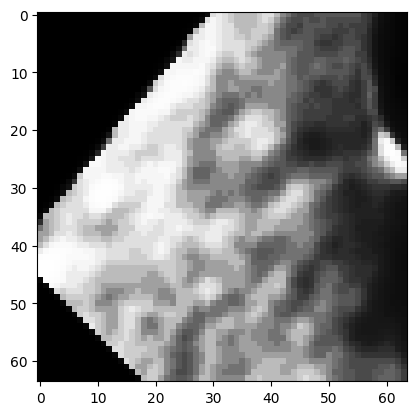

In [ ]:
plt.imshow(preprocessed_images[0])
plt.show()


In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

10056it [00:33, 296.08it/s]


Train Shape: (10056, 64, 64, 3)


In [ ]:
X_train[0]

array([[[128., 140., 140.],
        [127., 139., 139.],
        [129., 141., 141.],
        ...,
        [136., 138., 138.],
        [137., 139., 139.],
        [139., 141., 141.]],

       [[127., 139., 139.],
        [130., 142., 142.],
        [135., 147., 147.],
        ...,
        [136., 138., 138.],
        [137., 139., 139.],
        [136., 138., 138.]],

       [[127., 139., 139.],
        [126., 138., 138.],
        [125., 137., 137.],
        ...,
        [137., 139., 139.],
        [138., 140., 140.],
        [139., 141., 141.]],

       ...,

       [[112., 117., 116.],
        [113., 118., 117.],
        [116., 121., 120.],
        ...,
        [124., 125., 123.],
        [123., 124., 122.],
        [124., 125., 123.]],

       [[113., 118., 117.],
        [117., 122., 121.],
        [119., 124., 123.],
        ...,
        [123., 124., 122.],
        [125., 126., 124.],
        [123., 124., 122.]],

       [[125., 130., 129.],
        [113., 118., 117.],
        [114., 1

In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [ ]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

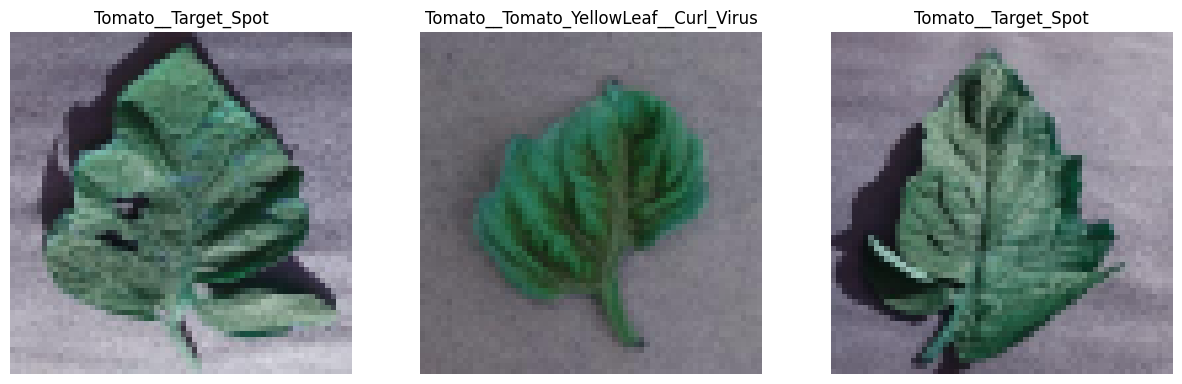

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model

# Assuming SIZE, N_ch, X_train, Y_train, X_val, Y_val, and other constants are defined

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(13, activation='softmax', name='root')(x)

    model = Model(input, output)

    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

model = build_densenet()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

datagen.fit(X_train)

hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                           steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=2,
                           callbacks=[annealer, checkpoint],
                           validation_data=(X_val, Y_val))


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_148 (Conv2D)         (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_149 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                           

InvalidArgumentError: ignored

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

ValueError: ignored

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29084464/29084464 [==============================] - 0s 0us/step


ValueError: ignored